In [14]:
from plot_utils import *
import numpy as np


# Next reaction algorithm

In [15]:
from scipy.special import factorial
from scipy.special import comb

# mass-action
def stochastic_ma(x, rates, produced):
    """ Stochastic mass action

    Args:
        x (np.array): number of molecules of each chemical species.
        rates (np.array): rate of each reaction
        produced (np.array): number of molecules of each chemical species that is produced in the reaction

    Returns:
        _type_: _description_
    """

    n  = x.shape[0] # number of species.
    m  = len(rates) # number of reactions.
    λk = np.full((m, 1), np.nan) # intensity function

    for i, κi in enumerate(rates):
        λk[i, :] = κi * np.prod(factorial(produced[i,:]) * comb(x, produced[i,:]))

    return λk

def simulate_next_reaction_method(x0, time, κ, produced, consumed, t_start=0):
    n = x0.shape[0]
    m = produced.shape[0]

    τ_min   = t_start
    t_max   = time
    x       = np.full((n, t_max), np.nan)
    x[:, 0] = np.squeeze(x0)

    λk       = stochastic_ma(x[:, 0], κ, produced)
    rk       = np.random.rand(m, 1)
    τk       = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk)
    times    = np.full((t_max), np.nan)
    times[0] = τ_min

    for i in range(1, t_max):
        lk       = np.argmin(τk)
        τ_min    = τk[lk]
        times[i] = τ_min

        x[:, i] = x[:, i-1] + produced[lk, :] - consumed[lk, :]
        λk_new  = stochastic_ma(x[:, i], κ, produced)

        τk     = np.divide(λk, λk_new, out=1/λk_new, where=λk_new!=0) * (τk-τ_min) + τ_min
        τk[lk] = τ_min
        λk     = λk_new
        rk     = np.random.rand(m, 1)
        τk     = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk) + τ_min

    return x, times

def gillespie(x0, time, κ, produced, consumed, t_start=0):
    n = x0.shape[0]
    m = produced.shape[0]

    x       = np.full((n, time), np.nan)
    x[:, 0] = np.squeeze(x0)

    times    = np.full((time), np.nan)
    times[0] = t_start

    for t in range(1, time):

        λk       = stochastic_ma(x[:, t-1], κ, produced)
        times[t] = times[t-1] +  (1/np.sum(λk))*np.log(1/np.random.random())

        # choose next reaction
        lk = 0
        cs = np.random.random() * np.sum(λk) - λk[lk]
        while cs > 0:
            lk = lk + 1
            cs = cs - λk[lk]

        x[:, t] = x[:, t-1] + produced[lk, :] - consumed[lk, :]

    return x, times

def gillespie2(x0, time, κ, produced, consumed, t_start=0):
    n = x0.shape[0]
    m = produced.shape[0]

    x        = np.full((n, time), np.nan)
    x[:, 0]  = np.squeeze(x0)

    times    = np.full((time), np.nan)
    times[0] = t_start

    for t in range(1, time):

        λk       = stochastic_ma(x[:, t-1], κ, produced)
        times[t] = times[t-1] +  (1/np.sum(λk)) * np.log(1/np.random.random())

        # probability of next reaction
        P_next = np.squeeze(λk/np.sum(λk))

        # choose next reaction
        lk      = np.random.choice(m, p=P_next)
        x[:, t] = x[:, t-1] + produced[lk, :] - consumed[lk, :]

    return x, times

def tau_leaping(x0, time, κ, produced, consumed, t_start=0, δt=0.01):
    n = x0.shape[0]
    m = produced.shape[0]

    x        = np.full((n, time), np.nan)
    x[:, 0]  = np.squeeze(x0)
    times    = np.full((time), np.nan)
    times[0] = t_start

    for t in range(1, time):
        # propensities
        λk = stochastic_ma(x[:, t-1], κ, produced)
        δλ = np.random.poisson(λk * δt)

        times[t] = times[t-1] + δt
        δx       = δλ * (produced - consumed)
        x[:, t]  = x[:, t-1] + np.sum(δx, 0)

    return x, times


In [16]:
n = 5 # number of chemical species.
m = 8 # number of reactions.

# number of molecules of each chemical species that is consumed in the reaction, v_k
consumed = np.array([[1, 0, 0, 0, 0], # reaction 1
                     [0, 1, 0, 0, 0], # reaction 2
                     [0, 1, 0, 0, 0], # reaction 3
                     [0, 0, 1, 0, 0], # reaction 4
                     [0, 0, 2, 0, 0], # reaction 5
                     [0, 0, 0, 1, 0], # reaction 6
                     [1, 0, 0, 1, 0], # reaction 7
                     [0, 0, 0, 0, 1], # reaction 8
                        ])

# number of molecules of each chemical species that is produced in the reaction, v^'_k
produced = np.array([[1, 1, 0, 0, 0], # reaction 1
                     [0, 1, 1, 0, 0], # reaction 2
                     [0, 0, 0, 0, 0], # reaction 3
                     [0, 0, 0, 0, 0], # reaction 4
                     [0, 0, 0, 1, 0], # reaction 5
                     [0, 0, 0, 0, 0], # reaction 6
                     [0, 0, 0, 0, 1], # reaction 7
                     [1, 0, 0, 1, 0], # reaction 7
                        ])

κs1 = [200, 10, 25, 1, 0.01, 1, 0, 0]
κs2 = [200, 10, 25, 1, 0.01, 1, 2, 0.2]

# initial conditions
x0   = np.array([[1, 10, 50, 10, 0]]).T

# time to simulate
time = 15
dt   = 2.5e-04


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:37: RuntimeWarning: divide by zero encountered in divide
  τk       = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  times[i] = τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:49: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(λk, λk_new, out=1/λk_new, where=λk_new!=0) * (τk-τ_min) + τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:53: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk) + τ_min


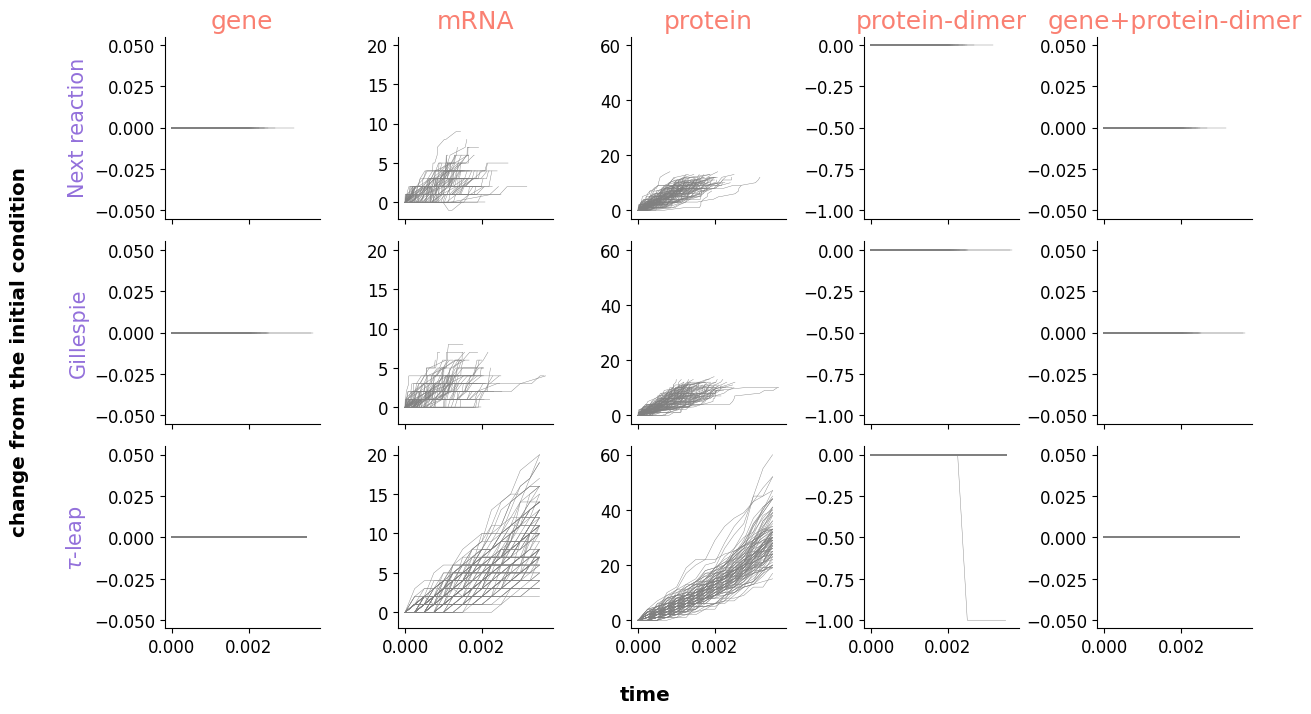

In [17]:

fig, ax = plt.subplots(3, 5, figsize=(12.5, 7.2), sharex=True, sharey="col")

for k in range(100):
    x_sim_nr, t_sim_nr = simulate_next_reaction_method(x0, time, κs1, produced, consumed, t_start=0)
    x_sim_gl, t_sim_gl = gillespie(x0, time, κs1, produced, consumed, t_start=0)
    x_sim_tl, t_sim_tl = tau_leaping(x0, time, κs1, produced, consumed, t_start=0, δt=dt)

    for i in range(5):
        ax[0, i].plot(t_sim_nr, x_sim_nr[i, :]-x0[i], color="gray", lw=0.3)
        ax[1, i].plot(t_sim_gl, x_sim_gl[i, :]-x0[i], color="gray", lw=0.3)
        ax[2, i].plot(t_sim_tl, x_sim_tl[i, :]-x0[i], color="gray", lw=0.3)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

titles = ["gene", "mRNA", "protein", "protein-dimer", "gene+protein-dimer"]
for i in range(5):
    ax[0, i].set_title(titles[i], color="salmon")

for i in range(3):
    ax[i, 0].set_ylabel(["Next reaction", "Gillespie", r"$\tau$-leap"][i], color="mediumpurple")

fig.supylabel("change from the initial condition", weight="bold", x=-0.008)
fig.supxlabel("time", weight="bold")

plt.tight_layout()

fig.savefig("figures/integration_methods_A_01.png", bbox_inches="tight", dpi=300)


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:37: RuntimeWarning: divide by zero encountered in divide
  τk       = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  times[i] = τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:49: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(λk, λk_new, out=1/λk_new, where=λk_new!=0) * (τk-τ_min) + τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:53: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk) + τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw00

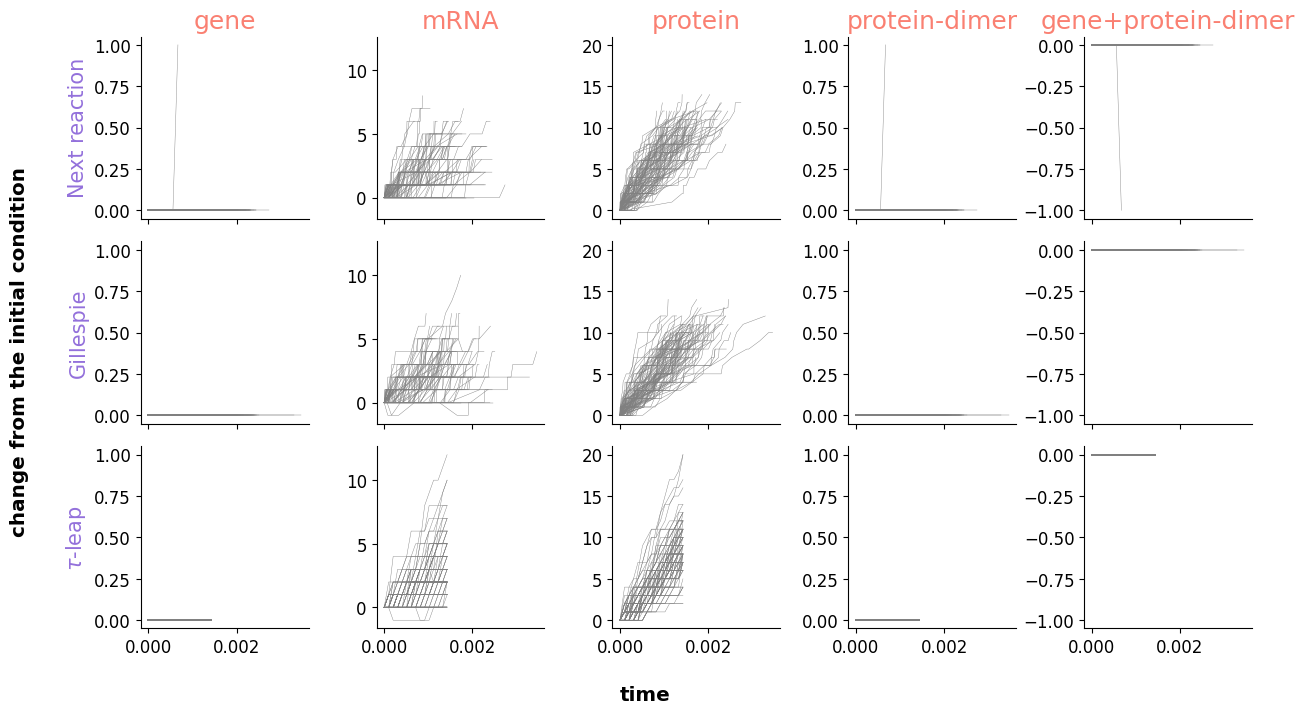

In [18]:
dt = 0.00010185969793278822

fig, ax = plt.subplots(3, 5, figsize=(12.5, 7.2), sharex=True, sharey="col")

for k in range(100):
    x_sim_nr, t_sim_nr = simulate_next_reaction_method(x0, time, κs2, produced, consumed, t_start=0)
    x_sim_tl, t_sim_tl = tau_leaping(x0, time, κs2, produced, consumed, t_start=0, δt=dt)
    x_sim_gl, t_sim_gl = gillespie(x0, time, κs2, produced, consumed, t_start=0)

    for i in range(5):
        ax[0, i].plot(t_sim_nr, x_sim_nr[i, :] - x0[i], color="gray", lw=0.3)
        ax[1, i].plot(t_sim_gl, x_sim_gl[i, :] - x0[i], color="gray", lw=0.3)
        ax[2, i].plot(t_sim_tl, x_sim_tl[i, :] - x0[i], color="gray", lw=0.3)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

titles = ["gene", "mRNA", "protein", "protein-dimer", "gene+protein-dimer"]
for i in range(5):
    ax[0, i].set_title(titles[i], color="salmon")

for i in range(3):
    ax[i, 0].set_ylabel(["Next reaction", "Gillespie", r"$\tau$-leap"][i], color="mediumpurple")

fig.supylabel("change from the initial condition", weight="bold", x=-0.008)
fig.supxlabel("time", weight="bold")

plt.tight_layout()

fig.savefig("figures/integration_methods_A_02.png", bbox_inches="tight", dpi=300)

In [19]:
dt = 0.00015
dt = 2.5e-04

num_sims = 800

x_all = np.full((3, 5, time, num_sims), np.nan)
t_all = np.full((3, time, num_sims), np.nan)

for k in range(num_sims):
    x_all[0, :, :, k], t_all[0, :, k] = simulate_next_reaction_method(x0, time, κs1, produced, consumed, t_start=0)
    x_all[1, :, :, k], t_all[1, :, k] = gillespie2(x0, time, κs1, produced, consumed, t_start=0)
    x_all[2, :, :, k], t_all[2, :, k] = tau_leaping(x0, time, κs1, produced, consumed, t_start=0, δt=dt)


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:37: RuntimeWarning: divide by zero encountered in divide
  τk       = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  times[i] = τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:49: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(λk, λk_new, out=1/λk_new, where=λk_new!=0) * (τk-τ_min) + τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:53: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk) + τ_min


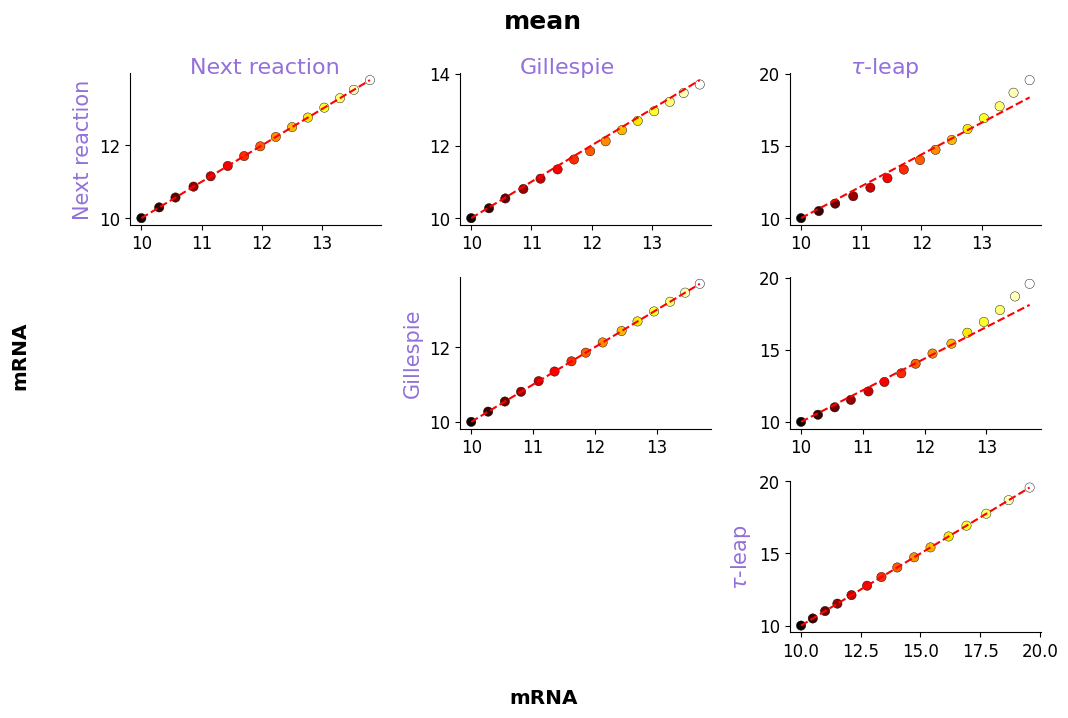

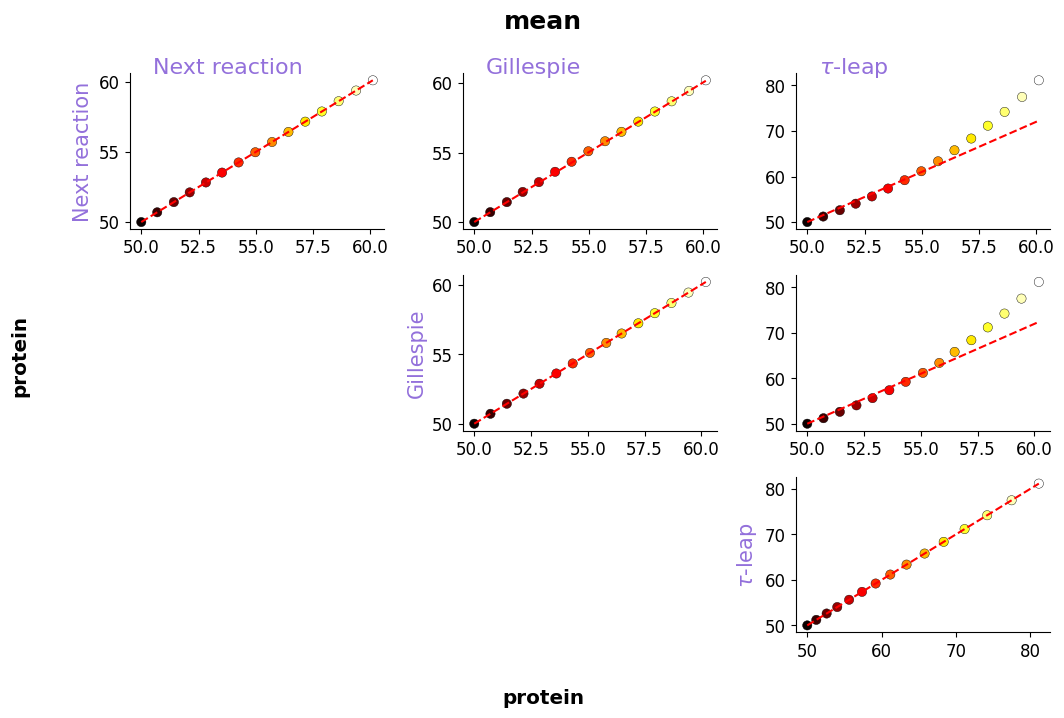

In [20]:
import matplotlib as mpl
cmap   = mpl.colormaps['hot']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, time))

def linear_regression(x, y):
    n = x.shape[0]
    A = np.vstack([x, np.ones(n)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

variables = ["gene", "mRNA", "protein", "protein-dimer", "gene+protein-dimer"]

for i_var in  [1, 2]:
    fig, ax = plt.subplots(3, 3, figsize=(10.5, 7.2), sharex=False, sharey=False)
    for i in range(3):
        for j in range(3):
            if j<i:
                ax[i, j].remove()
                continue

            var_i = x_all[i, i_var, :, :]
            var_j = x_all[j, i_var, :, :]

            x_sim = np.ma.masked_invalid(var_i).mean(-1)
            y_sim = np.ma.masked_invalid(var_j).mean(-1)
            ax[i, j].scatter(x_sim, y_sim, color="gray",
                                        facecolor=colors, edgecolor="k", lw=0.3, s=45)

            x = np.ma.masked_invalid(t_all[i, :, :]).mean(-1)
            y = np.ma.masked_invalid(t_all[j, :, :]).mean(-1)
            m, b = linear_regression(x, y)

            max_x  = np.max(np.mean(var_i, -1)[-1])
            x_line = np.linspace(np.mean(var_i, -1)[0], max_x, 100)

            ax[i, j].plot(x_line, m*(x_line-x_line[0])+y_sim[0], color="red", ls="--")

    methods = ["Next reaction", "Gillespie", r"$\tau$-leap"]

    for i in range(3):
        _, yup   = ax[0, i].get_ylim()
        xdown, _ = ax[0, i].get_xlim()
        ax[0, i].text(x=xdown+1, y=yup, s=methods[i], color="mediumpurple", size=16)

    for i in range(3):
        ax[i, i].set_ylabel(methods[i], color="mediumpurple")

    for axi in ax.flatten():
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)

    fig.supylabel(variables[i_var],
                    weight = "bold",
                    x      = -0.008)
    fig.supxlabel(variables[i_var],
                    weight = "bold")
    fig.suptitle("mean", weight="bold")

    plt.tight_layout()

    fig.savefig(f"figures/comparison_moments_B_mean_{variables[i_var]}.png", bbox_inches="tight", dpi=300)

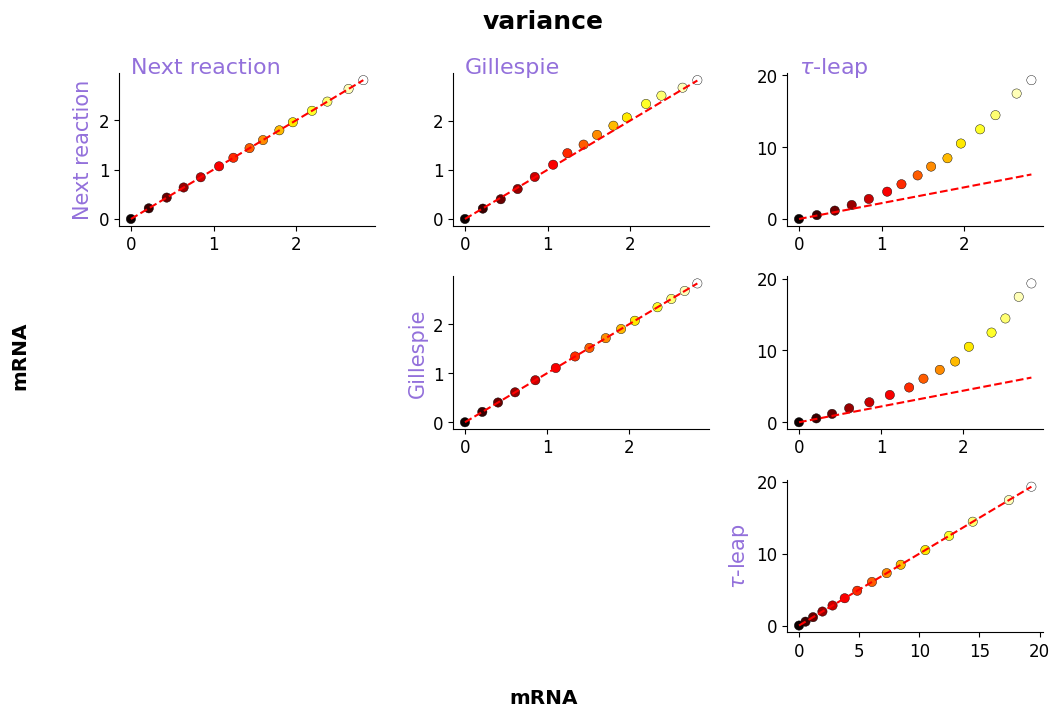

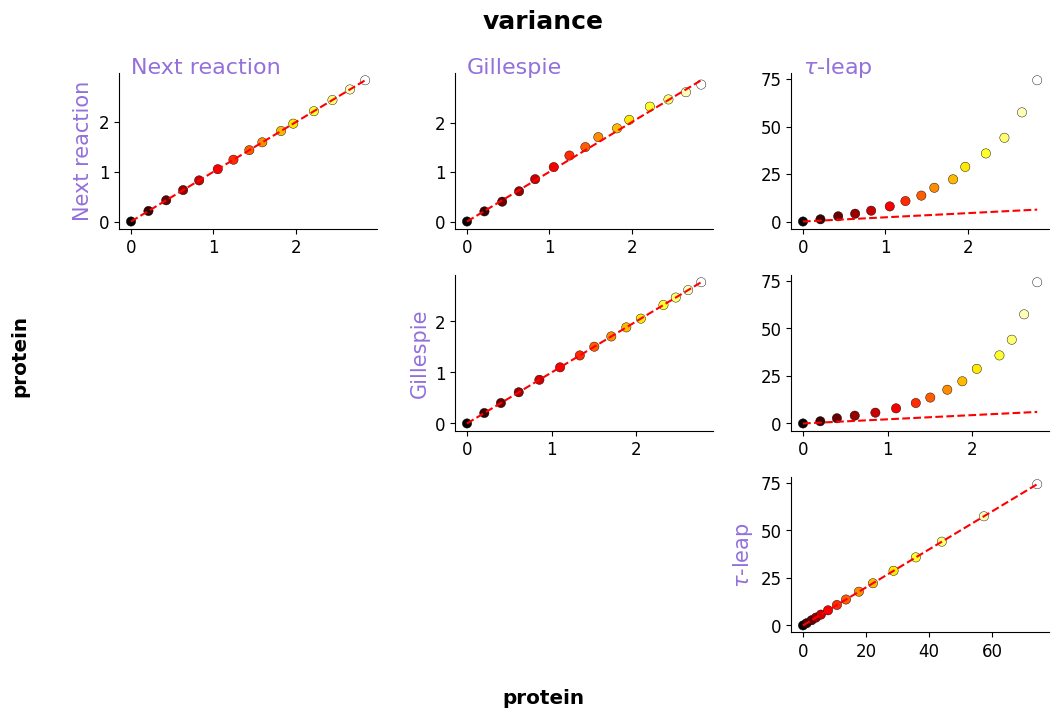

In [21]:
import matplotlib as mpl
cmap   = mpl.colormaps['hot']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, time))

def linear_regression(x, y):
    n = x.shape[0]
    A = np.vstack([x, np.ones(n)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

variables = ["gene", "mRNA", "protein", "protein-dimer", "gene+protein-dimer"]

for i_var in  [1, 2]:
    fig, ax = plt.subplots(3, 3, figsize=(10.5, 7.2), sharex=False, sharey=False)
    for i in range(3):
        for j in range(3):
                if j<i:
                    ax[i, j].remove()
                    continue

                var_i = x_all[i, i_var, :, :]
                var_j = x_all[j, i_var, :, :]

                x_sim = np.ma.masked_invalid(var_i).var(-1)
                y_sim = np.ma.masked_invalid(var_j).var(-1)
                ax[i, j].scatter(x_sim, y_sim, color="gray",
                                            facecolor=colors, edgecolor="k", lw=0.3, s=45)

                x = np.ma.masked_invalid(t_all[i, :, :]).mean(-1)
                y = np.ma.masked_invalid(t_all[j, :, :]).mean(-1)
                m, b = linear_regression(x, y)

                max_x  = np.max(np.var(var_i, -1)[-1])
                x_line = np.linspace(np.var(var_i, -1)[0], max_x, 100)
                ax[i, j].plot(x_line, m*(x_line-x_line[0])+y_sim[0], color="red", ls="--")

    methods = ["Next reaction", "Gillespie", r"$\tau$-leap"]

    for i in range(3):
        _, yup = ax[0, i].get_ylim()
        ax[0, i].text(x=0, y=yup, s=methods[i], color="mediumpurple", size=16)

    for i in range(3):
        ax[i, i].set_ylabel(methods[i], color="mediumpurple")

    for axi in ax.flatten():
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)

    fig.supylabel(variables[i_var],
                    weight = "bold",
                    x      = -0.008)
    fig.supxlabel(variables[i_var],
                    weight = "bold")
    fig.suptitle("variance", weight="bold")

    plt.tight_layout()

    fig.savefig(f"figures/comparison_moments_B_var_{variables[i_var]}.png", bbox_inches="tight", dpi=300)

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:37: RuntimeWarning: divide by zero encountered in divide
  τk       = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  times[i] = τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:49: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(λk, λk_new, out=1/λk_new, where=λk_new!=0) * (τk-τ_min) + τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:53: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk) + τ_min


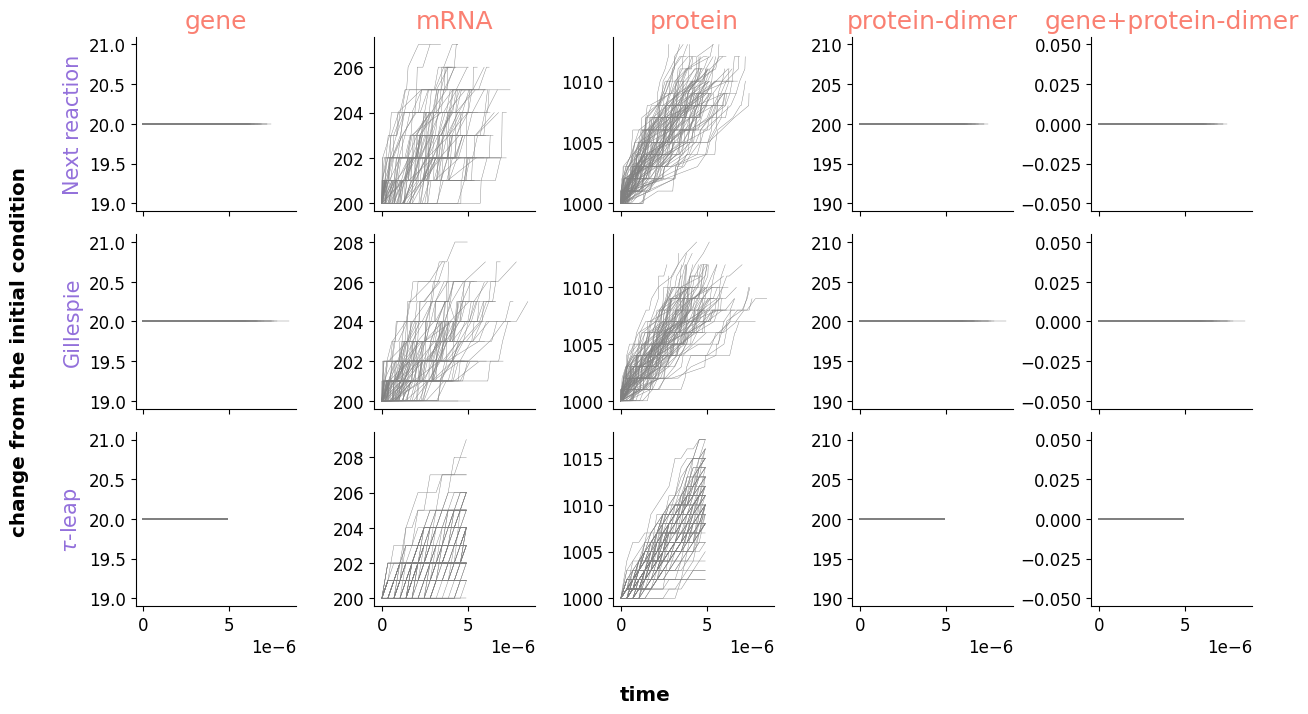

In [37]:
dt  = 3.5e-07
x02 = np.array([[20, 200, 1000, 200, 0]]).T

fig, ax = plt.subplots(3, 5, figsize=(12.5, 7.2), sharex="col", sharey=False)

for k in range(100):
    x_sim_nr, t_sim_nr = simulate_next_reaction_method(x02, time, κs1, produced, consumed, t_start=0)
    x_sim_gl, t_sim_gl = gillespie(x02, time, κs1, produced, consumed, t_start=0)
    x_sim_tl, t_sim_tl = tau_leaping(x02, time, κs1, produced, consumed, t_start=0, δt=dt)

    for i in range(5):
        ax[0, i].plot(t_sim_nr, x_sim_nr[i, :], color="gray", lw=0.3)
        ax[1, i].plot(t_sim_gl, x_sim_gl[i, :], color="gray", lw=0.3)
        ax[2, i].plot(t_sim_tl, x_sim_tl[i, :], color="gray", lw=0.3)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

titles = ["gene", "mRNA", "protein", "protein-dimer", "gene+protein-dimer"]
for i in range(5):
    ax[0, i].set_title(titles[i], color="salmon")

for i in range(3):
    ax[i, 0].set_ylabel(["Next reaction", "Gillespie", r"$\tau$-leap"][i], color="mediumpurple")

fig.supylabel("change from the initial condition", weight="bold", x=-0.008)
fig.supxlabel("time", weight="bold")

plt.tight_layout()

fig.savefig("figures/integration_methods_C_01.png", bbox_inches="tight", dpi=300)

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:37: RuntimeWarning: divide by zero encountered in divide
  τk       = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  times[i] = τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:49: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(λk, λk_new, out=1/λk_new, where=λk_new!=0) * (τk-τ_min) + τ_min
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_18758/3432965018.py:53: RuntimeWarning: divide by zero encountered in divide
  τk     = np.divide(1, λk, out=1/λk, where=λk!=0) * np.log(1/rk) + τ_min


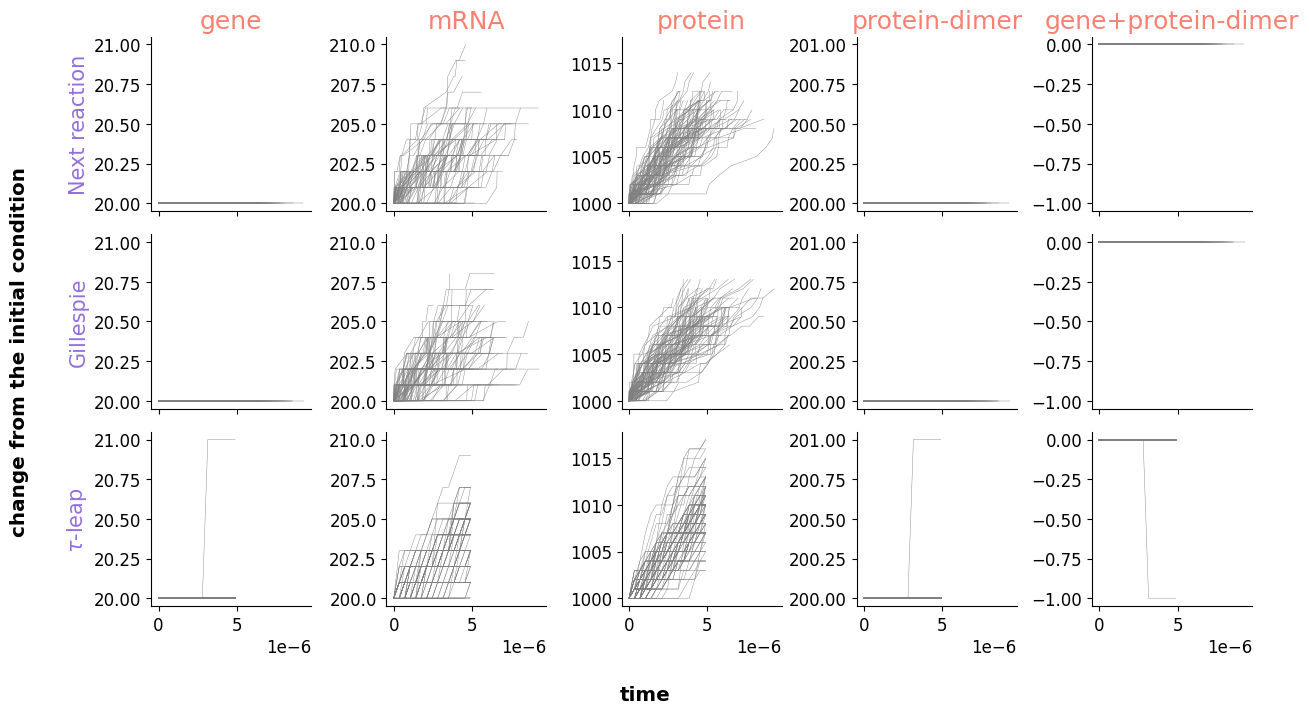

In [38]:
x02   = np.array([[20, 200, 1000, 200, 0]]).T

fig, ax = plt.subplots(3, 5, figsize=(12.5, 7.2), sharex="col", sharey="col")

for k in range(100):
    x_sim_nr, t_sim_nr = simulate_next_reaction_method(x02, time, κs2, produced, consumed, t_start=0)
    x_sim_gl, t_sim_gl = gillespie(x02, time, κs2, produced, consumed, t_start=0)
    x_sim_tl, t_sim_tl = tau_leaping(x02, time, κs2, produced, consumed, t_start=0, δt=dt)

    for i in range(5):
        ax[0, i].plot(t_sim_nr, x_sim_nr[i, :], color="gray", lw=0.3)
        ax[1, i].plot(t_sim_gl, x_sim_gl[i, :], color="gray", lw=0.3)
        ax[2, i].plot(t_sim_tl, x_sim_tl[i, :], color="gray", lw=0.3)

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

titles = ["gene", "mRNA", "protein", "protein-dimer", "gene+protein-dimer"]
for i in range(5):
    ax[0, i].set_title(titles[i], color="salmon")

for i in range(3):
    ax[i, 0].set_ylabel(["Next reaction", "Gillespie", r"$\tau$-leap"][i], color="mediumpurple")

fig.supylabel("change from the initial condition", weight="bold", x=-0.008)
fig.supxlabel("time", weight="bold")

plt.tight_layout()

fig.savefig("figures/integration_methods_C_02.png", bbox_inches="tight", dpi=300)